In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import fftconvolve
%matplotlib widget

In [45]:
class SimParams(object):
    def __init__(self, n = 100, n_steps=10000, b_top = 0.5, multiprocess = True, t_min = 1.6, t_max = 3.6, t_step = 0.1):
        self.n = n
        self.n_steps = n_steps
        self.b_top = b_top
        self.multiprocess = multiprocess
        self.t_min = t_min
        self.t_max = t_max
        self.t_step = t_step
    def __str__(self):
        return f"\n\tn:{self.n}\n\tn_steps:{self.n_steps}\n\tmultiprocess:{self.multiprocess}\n\tb_top:{self.b_top}\n\tt_min:{self.t_min}\n\tt_max:{self.t_max}\n\tt_step:{self.t_step}"

def _run_raw(test_path, snapshots=False, params: SimParams = SimParams()):
    !cd .. && python ising.py N:{params.n} multiprocess:{"t" if params.multiprocess else "f"} b_top:{params.b_top} t_min:{params.t_min} t_max:{params.t_max} t_step:{params.t_step}

def copy_results(test_path, snapshots=False):
    !mv ../data/* {test_path}/result/
    if snapshots:
        !mv ../snapshots/* {test_path}/snapshots/

def store_metadata(test_path, snapshots, n_trials, params):
    with open(f"{test_path}/metadata.txt", "w") as f:
        f.write(f"n_trials: {n_trials}\n")
        f.write(f"snapshots taken: {snapshots}\n")
        f.write(f"params: {params}\n")
        
def rerun(test_path, snapshots=False, params: SimParams = SimParams()):
    _run_raw(test_path, snapshots, params)
    copy_results(test_path, snapshots)
    store_metadata(test_path, snapshots, 1, params)
        
def run_many(test_path, n_trials, snapshots=False, params: SimParams = SimParams()):
    for i in range(n_trials):
        _run_raw(test_path, snapshots, params)
    copy_results(test_path, snapshots)
    store_metadata(test_path, snapshots, n_trials, params)

def new_test(test_path):
    !mkdir -p {test_path}/result
    !mkdir -p {test_path}/snapshots
    !mkdir -p {test_path}/plots
    

In [46]:
data_tests = "../../data_tests"
test_name = "fit-observables/many-runs-trial-3-fixN"
test_path = f"{data_tests}/{test_name}"
n_trials = 10 # How many times to run the simulation per temperature
params = SimParams(n = 100, n_steps=10000, b_top = 0.5, multiprocess = True, t_min = 1.6, t_max = 3.6, t_step = 0.1)

if False:
    #rerun(test_path)
    new_test(test_path)
    run_many(test_path, n_trials, snapshots=False, params=params)

inp["N"]             set to int     100
inp["b_top"]         set to float   0.5
inp["t_min"]         set to float   1.6
inp["t_max"]         set to float   3.6
inp["t_step"]        set to float   0.1

2D Ising Model Simulation; multi-core

Starting Temp 1.6
Starting Temp 1.7
Starting Temp 1.8
Starting Temp 2.0Starting Temp 1.9

Starting Temp 2.2
Starting Temp 2.1
Starting Temp 2.3
Starting Temp 2.4
Starting Temp 2.5
Starting Temp 2.6
Finished Temp 1.6
Starting Temp 2.7
Finished Temp 1.7
Starting Temp 2.8
Finished Temp 2.4
Finished Temp 1.8
Starting Temp 2.9
Starting Temp 3.0
Finished Temp 2.1
Starting Temp 3.1
Finished Temp 1.9
Starting Temp 3.2
Finished Temp 2.5
Starting Temp 3.3
Finished Temp 2.2
Starting Temp 3.4
Finished Temp 2.0
Starting Temp 3.5
Finished Temp 2.6
Finished Temp 2.3
Finished Temp 2.7
Finished Temp 2.8
Finished Temp 2.9
Finished Temp 3.2
Finished Temp 3.0
Finished Temp 3.1
Finished Temp 3.3
Finished Temp 3.4
Finished Temp 3.5
Closing listener
inp["N"]             se

In [47]:
# Read data from files
em = []
sc = []
ac = []

for trial in range(n_trials):
    em.append(pd.read_csv(f"{test_path}/result/{params.t_min:.2f}T{params.t_max:.2f}_EM_v{trial}.csv", skiprows=3))
    sc.append(pd.read_csv(f"{test_path}/result/{params.t_min:.2f}T{params.t_max:.2f}_SC_v{trial}.csv", skiprows=3))
    ac = sc # If we aren't taking autocorrelation every step
    # ac = pd.read_csv("data/0.00T5.00_AC_v0.csv", skiprows=3)

In [48]:
# Extract numpy arrays from dataframes

temp_size = len(em[0])
# shape: (temp)
temp = np.empty(len(em[0]))
temp[:] = em[0]["Temp"].to_numpy() # All temperatures are the same for all trials

# shape: (temp, trial)
e_mean = np.empty((temp_size, n_trials))
e_std = np.empty_like(e_mean)
m_mean = np.empty_like(e_mean)
m_std = np.empty_like(e_mean)

for trial in range(n_trials):
    e_mean[:, trial] = em[trial]["E_mean"].to_numpy()
    e_std[:, trial] = em[trial]["E_std"].to_numpy()
    m_mean[:, trial] = em[trial]["M_mean"].to_numpy()
    m_std[:, trial] = em[trial]["M_std"].to_numpy()
    
e_var = e_std ** 2
m_var = m_std ** 2

# shape: (temp, lattice_dist, trial)
sc_data = np.empty((len(temp), len(sc[0].columns) - 2, n_trials))
ac_data = np.empty((len(temp), len(sc[0].columns) - 2, n_trials))

for trial in range(n_trials):
    for lattice_dist, col_name in enumerate(sc[0].columns[1:-1]):
        sc_data[:, lattice_dist, trial] = sc[trial][col_name]
        ac_data[:, lattice_dist, trial] = ac[trial][col_name]
        
print(f"Test: {test_name}.\n{e_mean.size} runs ({temp_size} temperatures * {n_trials} trials each) in {temp[0]} <= T <= {temp[-1]}")
print(f"temp.shape = {temp.shape}, sc_data.shape = {sc_data.shape}, ac_data.shape = {ac_data.shape}")

Test: fit-observables/many-runs-trial-3-fixN.
200 runs (20 temperatures * 10 trials each) in 1.6 <= T <= 3.5000000000000018
temp.shape = (20,), sc_data.shape = (20, 49, 10), ac_data.shape = (20, 49, 10)


In [13]:
e_var_avg = e_var.mean(axis=1)
e_var_error = e_var.std(axis=1) / np.sqrt(n_trials)
m_var_avg = m_var.mean(axis=1)
m_var_error = m_var.std(axis=1) / np.sqrt(n_trials)



In [35]:
partition_radius = 0.1 # In units of T
analytic_T_c = 2.269
# 2.269 is the analytic critical temperature for the 2D Ising model
partition_l = temp.searchsorted(analytic_T_c - partition_radius) + 1
partition_r = temp.searchsorted(analytic_T_c + partition_radius)

In [43]:
log_r = lambda T, a, b, T_c: a + b * np.log((T - T_c) / T_c)
log_l = lambda T, a, b, T_c: a + b * np.log(-(T - T_c) / T_c)

e_var_p_pos, e_var_covm_pos = curve_fit(log_r, temp[partition_r:], e_var_avg[partition_r:], p0 = (0, -1, analytic_T_c), sigma=e_var_error[partition_r:])
e_var_p_neg, e_var_covm_neg = curve_fit(log_l, temp[:partition_l], e_var_avg[:partition_l], p0 = (0, -1, analytic_T_c), sigma=e_var_error[:partition_l])

Text(0, 0.5, 'Var(E) [$J^2$]')

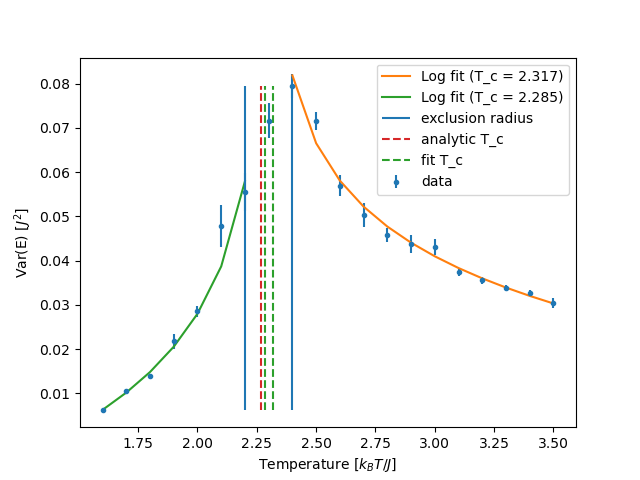

In [44]:
plt.close()
fig, ax = plt.subplots()
ax.errorbar(temp, e_var_avg, yerr=e_var_error, fmt=".", label="data")
ax.plot(temp[partition_r:], log_pos(temp[partition_r:], *e_var_p_pos), label=f"Log fit (T_c = {e_var_p_pos[2]:.3f})")
ax.plot(temp[:partition_l], log_neg(temp[:partition_l], *e_var_p_neg), label=f"Log fit (T_c = {e_var_p_neg[2]:.3f})")
ax.vlines([temp[partition_l - 1], temp[partition_r]], e_var_avg.min(), e_var_avg.max(), linestyles="solid", label="exclusion radius")
ax.vlines(analytic_T_c, e_var_avg.min(), e_var_avg.max(), linestyles="dashed", color="tab:red", label="analytic T_c")
ax.vlines([e_var_p_pos[2], e_var_p_neg[2]], e_var_avg.min(), e_var_avg.max(), linestyles="dashed", color="tab:green", label="fit T_c")
ax.legend()
ax.set_xlabel("Temperature [$k_B T / J$]")
ax.set_ylabel("Var(E) [$J^2$]")

In [ ]:
chi_powerlaw = lambda T, a, gamma, T_c: a * ((T - T_c) / T_c)**(-gamma)

partition = temp.searchsorted(2.269) # Approximate index of theoretical T_c

p_pos, covm_pos = curve_fit(log_pos, temp[partition:], e_var_avg[partition:], p0 = (0, -1, 2.269), sigma=e_var_error[partition:])
p_neg, covm_neg = curve_fit(log_neg, temp[:partition], e_var_avg[:partition], p0 = (0, -1, 2.269), sigma=e_var_error[:partition])

Text(0, 0.5, 'Var(M)')

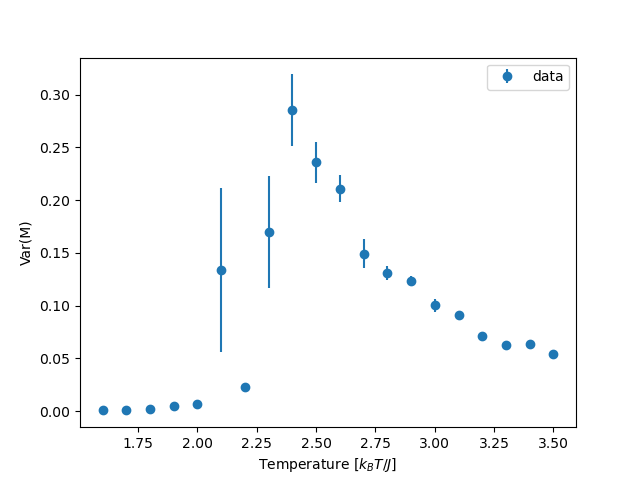

In [18]:
plt.close()
fig, ax = plt.subplots()
ax.errorbar(temp, m_var_avg, yerr=m_var_error, fmt="o", label="data")
#ax.plot(temp[partition:], log_pos(temp[partition:], *p_pos), label=f"Log fit (T_c = {p_pos[2]:.3f})")
#ax.plot(temp[:partition], log_neg(temp[:partition], *p_neg), label=f"Log fit (T_c = {p_neg[2]:.3f})")
ax.legend()
ax.set_xlabel("Temperature [$k_B T / J$]")
ax.set_ylabel("Var(M)")

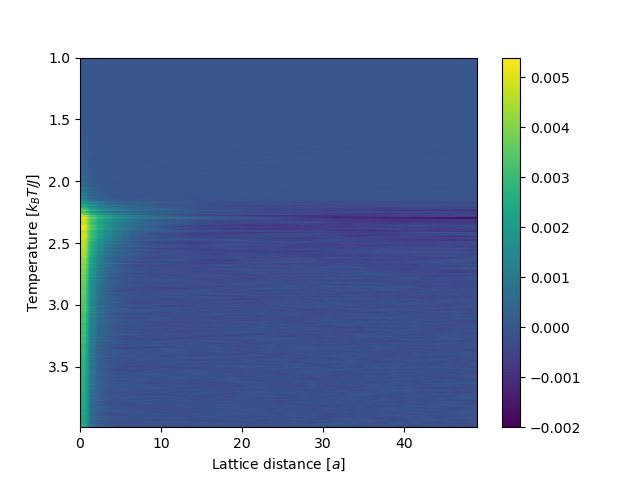

In [15]:
fig, ax = plt.subplots()
im = ax.imshow(sc_data, aspect="auto", extent=[0, sc_data.shape[1], temp[-1], temp[0]])
ax.set_ylabel("Temperature $[k_B T / J]$")
ax.set_xlabel("Lattice distance $[a]$")
fig.colorbar(im)

In [16]:
decay = lambda x, A, xi : A * np.exp(- x / xi) if xi != 0 else A
A = np.empty_like(temp)
xi = np.empty_like(temp)
x = np.arange(sc_data.shape[1])

for i in np.arange(len(temp)):
    if np.abs(sc_data[i, :]).max() != 0:
        (val_A, val_xi), covm = curve_fit(decay, x, sc_data[i, :], p0=(sc_data[i, 0], 1e0))
    else:
        val_A, val_xi = 0, 0
    A[i] = val_A
    xi[i] = val_xi if np.abs(val_xi) < sc_data.shape[1] else 0
    

print(f"xi.shape = {xi.shape}, A.shape = {A.shape}")
print(f"xi.min = {xi.min()}, xi.max = {xi.max()}")

xi.shape = (300,), A.shape = (300,)
xi.min = 0.0, xi.max = 5.058530611585292


/var/folders/h6/326nqt2x2ql8ggvhjlhhckh40000gn/T/ipykernel_94980/3491209615.py:1: RuntimeWarning: overflow encountered in exp
  decay = lambda x, A, xi : A * np.exp(- x / xi) if xi != 0 else A
/Users/adrianhall/miniconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [17]:
winsize = 20
wincenter = winsize // 2
window = np.full(winsize, 1/winsize)
mav_xi = fftconvolve(xi, window, mode="same")
mvstd_xi = fftconvolve((xi - mav_xi)**2, window, mode="same")**0.5
mav_A = fftconvolve(A, window, mode="same")
mvstd_A = fftconvolve((A - mav_A)**2, window, mode="same")**0.5
mavdomain = slice(wincenter, -(wincenter - 1))
print(mav_xi.shape, mav_A.shape, mavdomain)

(300,) (300,) slice(10, -9, None)


Text(0, 0.5, 'Correlation length $\\xi$')

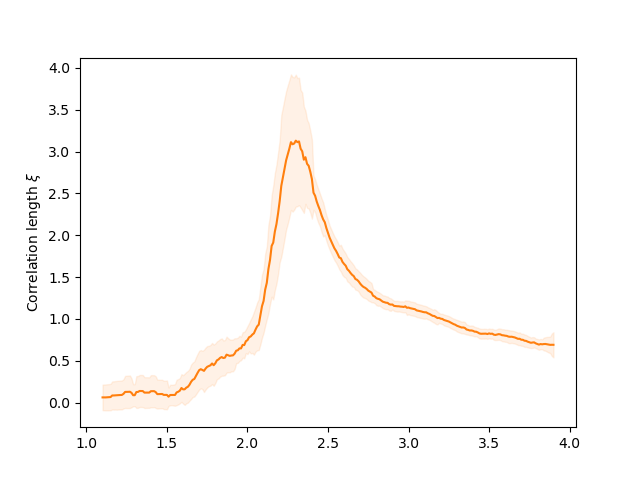

In [22]:
fig, ax = plt.subplots()
#ax2 = ax.twinx()
# ax.plot(temp[mavdomain], mav_A[mavdomain], label="A", color="tab:blue")
# ax.fill_between(temp[mavdomain], mav_A[mavdomain] + mvstd_A[mavdomain], mav_A[mavdomain] - mvstd_A[mavdomain], color="tab:blue", alpha=0.1)
# ax.yaxis.label.set_color("tab:blue")
# ax2.spines["left"].set_edgecolor("tab:blue")
# ax.set_ylabel("A")
ax.plot(temp[mavdomain], mav_xi[mavdomain], label="xi", color="tab:orange")
ax.fill_between(temp[mavdomain], mav_xi[mavdomain] + mvstd_xi[mavdomain], mav_xi[mavdomain] - mvstd_xi[mavdomain], color="tab:orange", alpha=0.1)
ax.set_ylabel("Correlation length $\\xi$")

2.3000000000000003 3.384398532732046


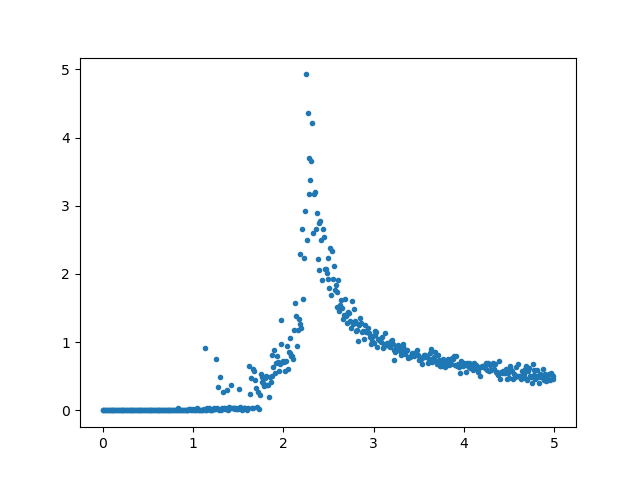

In [404]:
plt.close()
fig, ax = plt.subplots()
ax.scatter(temp, xi, marker=".")
print(temp[230], xi[230])

Test: bsanity/sanity. T = 2.26J, Fit = 2.72e-03exp(- x / 2.50)


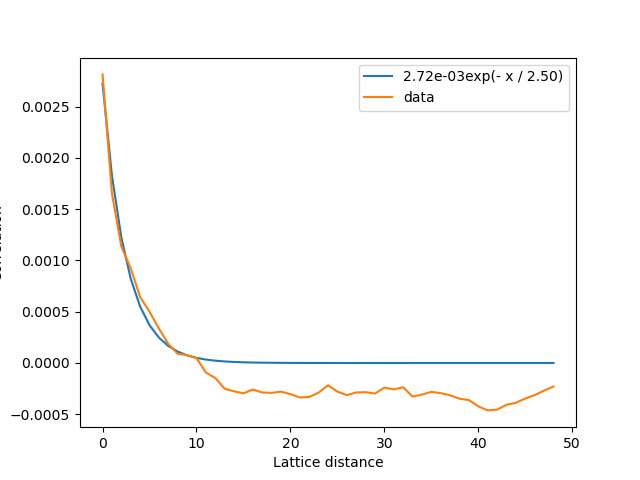

In [411]:
plt.close()
fig, ax = plt.subplots()
idx = temp.searchsorted(2.26)
#print(A[i], xi[i])
ax.plot(x, decay(x, A[idx], xi[idx]), label=f"{A[idx]:.2e}exp(- x / {xi[idx]:.2f})")
ax.plot(x, sc_data[idx], label="data")
ax.set_xlabel("Lattice distance")
ax.set_ylabel("Correlation")
# ax.plot(temp[tstart:tend], A, label="A")
# ax.plot(temp[tstart:tend], xi, label="xi")
ax.legend()
print(f"Test: {test_name}. T = {temp[idx]:.2f}J, Fit = {A[idx]:.2e}exp(- x / {xi[idx]:.2f})")

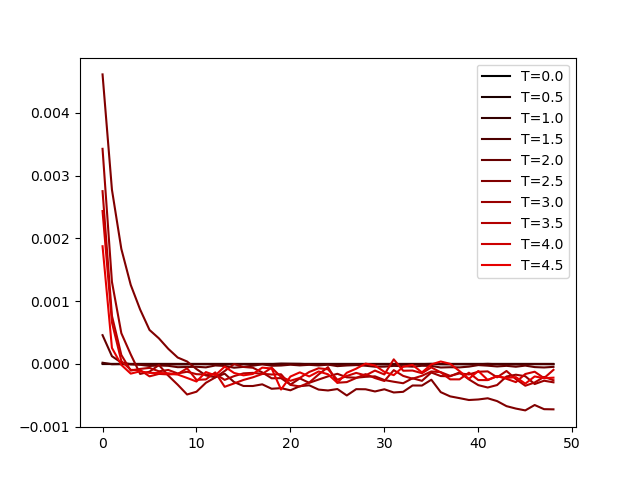

In [406]:


fig, ax = plt.subplots()
for i in np.arange(tstart, tend, (tend - tstart) // 10):
    ax.plot(sc_data[i, :], label=f"T={temp[i]}", color=(temp[i]/5, 0, 0))
    
ax.legend()